## Problem Statement
Predicting Turbine Energy Yield (TEY) using ambient variables as features.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold

from tensorflow import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from keras.models import Sequential
from keras_tuner.tuners import RandomSearch
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

import warnings
warnings.filterwarnings('ignore')

## 2. Import Dataset

In [2]:
df = pd.read_csv('gas_turbines.csv')
df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311
...,...,...,...,...,...,...,...,...,...,...,...
15034,9.0301,1005.6,98.460,3.5421,19.164,1049.7,546.21,111.61,10.400,4.5186,79.559
15035,7.8879,1005.9,99.093,3.5059,19.414,1046.3,543.22,111.78,10.433,4.8470,79.917
15036,7.2647,1006.3,99.496,3.4770,19.530,1037.7,537.32,110.19,10.483,7.9632,90.912
15037,7.0060,1006.8,99.008,3.4486,19.377,1043.2,541.24,110.74,10.533,6.2494,93.227


## About Dataset
* The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine.
* The Dataset includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables.

### Attribute Information:
#### The explanations of sensor measurements and their brief statistics are given below.

* Variable (Abbr) Unit Min Max Mean
* Ambient temperature (AT) C â€“6.23 37.10 17.71
* Ambient pressure (AP) mbar 985.85 1036.56 1013.07
* Ambient humidity (AH) (%) 24.08 100.20 77.87
* Air filter difference pressure (AFDP) mbar 2.09 7.61 3.93
* Gas turbine exhaust pressure (GTEP) mbar 17.70 40.72 25.56
* Turbine inlet temperature (TIT) C 1000.85 1100.89 1081.43
* Turbine after temperature (TAT) C 511.04 550.61 546.16
* Compressor discharge pressure (CDP) mbar 9.85 15.16 12.06
* Turbine energy yield (TEY) MWH 100.02 179.50 133.51
* Carbon monoxide (CO) mg/m3 0.00 44.10 2.37
* Nitrogen oxides (NOx) mg/m3 25.90 119.91 65.29

## 3. Data Exploration

In [3]:
df.isnull().any()

AT      False
AP      False
AH      False
AFDP    False
GTEP    False
TIT     False
TAT     False
TEY     False
CDP     False
CO      False
NOX     False
dtype: bool

In [4]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

### 3.1 Descriptive Analysis

In [5]:
df.shape

(15039, 11)

In [6]:
df.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

In [7]:
df.nunique()

AT      12086
AP        540
AH      12637
AFDP    11314
GTEP     8234
TIT       706
TAT      2340
TEY      4207
CDP      3611
CO      13096
NOX     11996
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,15039.0,17.764381,7.574323,0.522300,11.408000,18.1860,23.8625,34.9290
AP,15039.0,1013.199240,6.410760,985.850000,1008.900000,1012.8000,1016.9000,1034.2000
AH,15039.0,79.124174,13.793439,30.344000,69.750000,82.2660,90.0435,100.2000
AFDP,15039.0,4.200294,0.760197,2.087400,3.723900,4.1862,4.5509,7.6106
GTEP,15039.0,25.419061,4.173916,17.878000,23.294000,25.0820,27.1840,37.4020
TIT,15039.0,1083.798770,16.527806,1000.800000,1079.600000,1088.7000,1096.0000,1100.8000
TAT,15039.0,545.396183,7.866803,512.450000,542.170000,549.8900,550.0600,550.6100
TEY,15039.0,134.188464,15.829717,100.170000,127.985000,133.7800,140.8950,174.6100
CDP,15039.0,12.102353,1.103196,9.904400,11.622000,12.0250,12.5780,15.0810
CO,15039.0,1.972499,2.222206,0.000388,0.858055,1.3902,2.1604,44.1030


In [10]:
df.corr()["TEY"].sort_values(ascending=False)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

In [11]:
numerical_features = df.describe(include=["int64","float64"]).columns
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

## 4. Data Visualization

### 4.1 Univariate plots

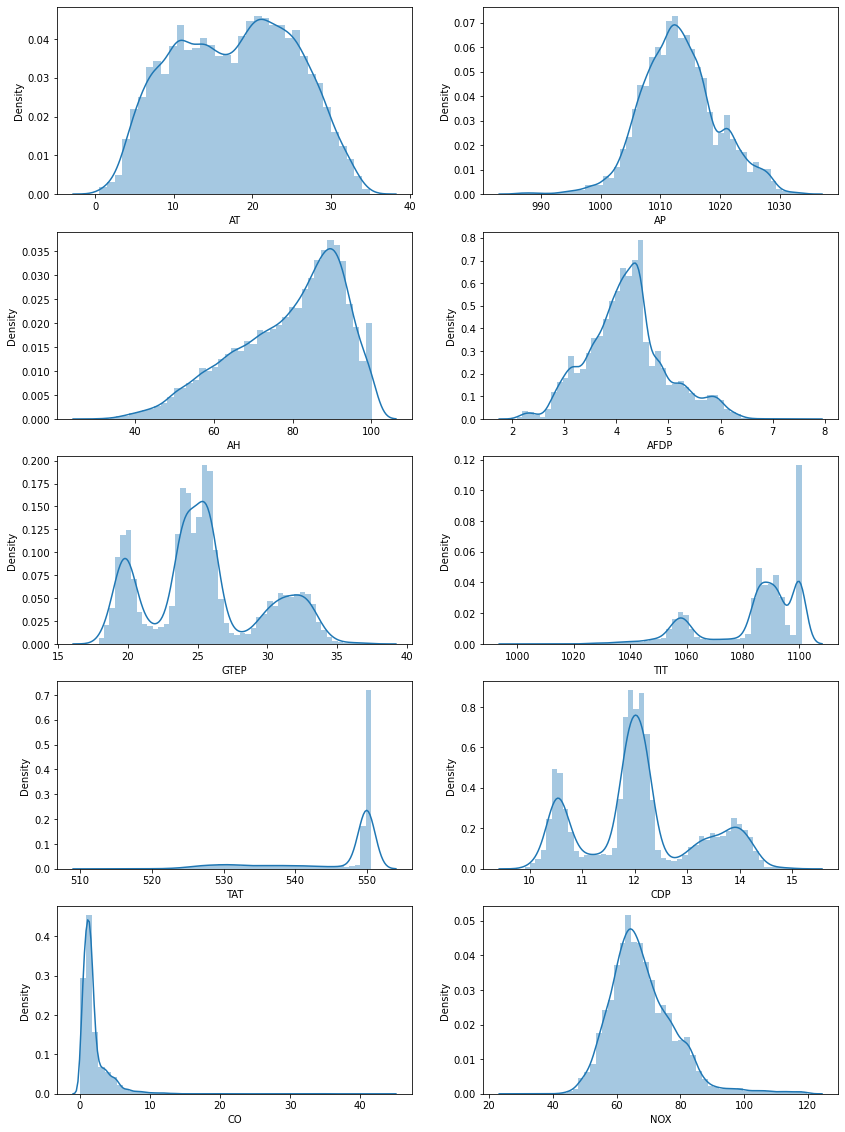

In [21]:
fig, ax = plt.subplots(5,2, figsize = (14,20))

sns.distplot(df.AT, ax = ax[0,0])
sns.distplot(df.AP, ax = ax[0,1])
sns.distplot(df.AH, ax = ax[1,0])
sns.distplot(df.AFDP, ax = ax[1,1])
sns.distplot(df.GTEP, ax = ax[2,0])
sns.distplot(df.TIT, ax = ax[2,1])
sns.distplot(df.TAT, ax = ax[3,0])
sns.distplot(df.CDP, ax = ax[3,1])
sns.distplot(df.CO, ax = ax[4,0])
sns.distplot(df.NOX, ax = ax[4,1])

plt.show()

### Detect observations with more than one outlier

In [13]:
def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    for col in df.columns.tolist():         # iterate over features(columns)
        Q1 = np.percentile(df[col],25)      # 1st quartile (25%)
        Q3 = np.percentile(df[col],75)      # 3rd quartile (75%)
        IQR = Q3 - Q1                       # Interquartile rrange (IQR)

        outlier_step = 1.5 * IQR            # outlier step
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features]))))

The dataset contains 1543 observations with more than 2 outliers


In [14]:
numerical_features

['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO', 'NOX']

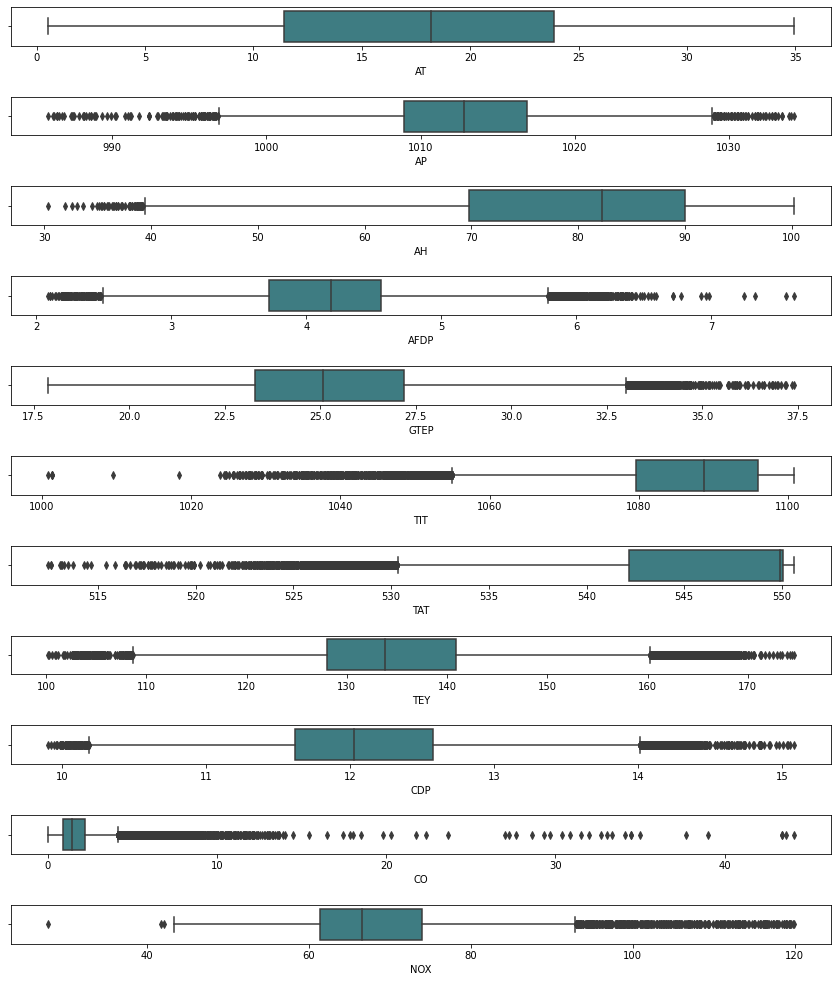

In [15]:
outlier = df.copy() 
fig, axes=plt.subplots(11,1,figsize=(12,14),sharex=False,sharey=False)
sns.boxplot(x='AT',data= outlier,palette='crest',ax=axes[0])
sns.boxplot(x='AP',data= outlier,palette='crest',ax=axes[1])
sns.boxplot(x='AH',data= outlier,palette='crest',ax=axes[2])
sns.boxplot(x='AFDP',data= outlier,palette='crest',ax=axes[3])
sns.boxplot(x='GTEP',data= outlier,palette='crest',ax=axes[4])
sns.boxplot(x='TIT',data= outlier,palette='crest',ax=axes[5])
sns.boxplot(x='TAT',data= outlier,palette='crest',ax=axes[6])
sns.boxplot(x='TEY',data= outlier,palette='crest',ax=axes[7])
sns.boxplot(x='CDP',data= outlier,palette='crest',ax=axes[8])
sns.boxplot(x='CO',data= outlier,palette='crest',ax=axes[9])
sns.boxplot(x='NOX',data= outlier,palette='crest',ax=axes[10])
plt.tight_layout(pad=2.0)

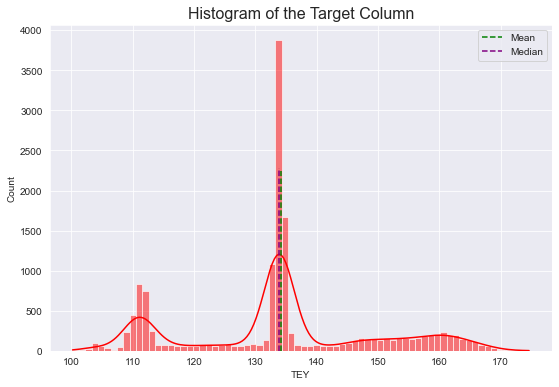

In [16]:
sns.set_style("darkgrid")
plt.figure(figsize=(9,6))
sns.histplot(data= df, x= "TEY", color= "red", kde= True)
plt.axvline(x=df["TEY"].mean(), ymax= 0.55, color= "green", linestyle= '--', label= "Mean")
plt.axvline(x=df["TEY"].median(), ymax= 0.56, color= "purple", linestyle= '--',label= "Median")
plt.title("Histogram of the Target Column", fontsize=16)
plt.legend();

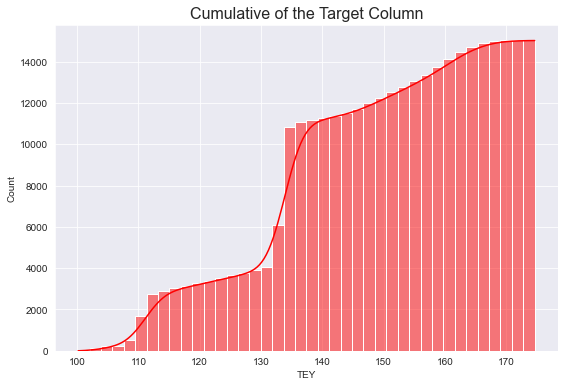

In [17]:
plt.figure(figsize = (9,6))
sns.histplot(df["TEY"], kde= True, bins= 40, color= "red", cumulative= True)
plt.title("Cumulative of the Target Column", fontsize=16);

### Unsurprisingly, Mostly none of the features are on the same scale as we already saw in the previous section.

### Multivariate Analysis

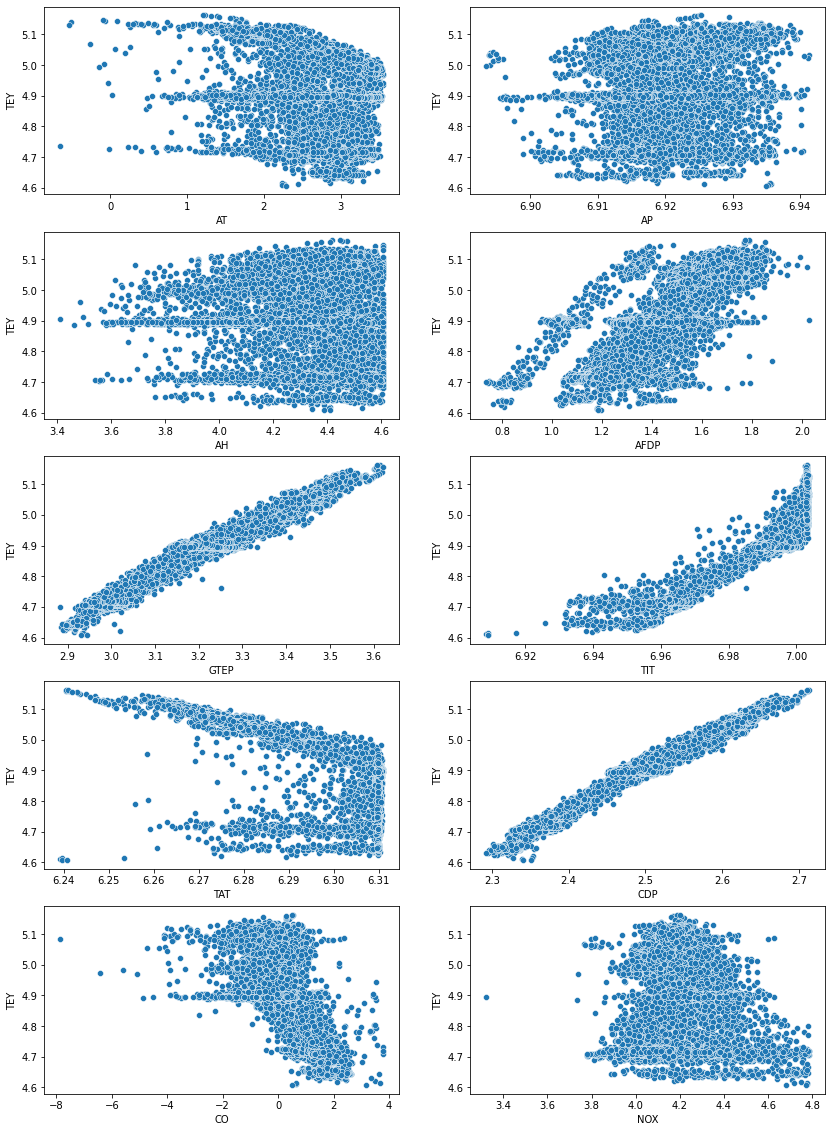

In [34]:
fig, ax = plt.subplots(5,2, figsize = (14,20))

sns.scatterplot(np.log(df['AT']), np.log(df['TEY']),ax= ax[0,0])
sns.scatterplot(np.log(df['AP']), np.log(df['TEY']), ax= ax[0,1])
sns.scatterplot(np.log(df['AH']), np.log(df['TEY']), ax= ax[1,0])
sns.scatterplot(np.log(df['AFDP']), np.log(df['TEY']),ax= ax[1,1])
sns.scatterplot(np.log(df['GTEP']), np.log(df['TEY']), ax= ax[2,0])
sns.scatterplot(np.log(df['TIT']), np.log(df['TEY']), ax= ax[2,1])
sns.scatterplot(np.log(df['TAT']), np.log(df['TEY']), ax= ax[3,0])
sns.scatterplot(np.log(df['CDP']), np.log(df['TEY']), ax= ax[3,1])
sns.scatterplot(np.log(df['CO']), np.log(df['TEY']), ax= ax[4,0])
sns.scatterplot(np.log(df['NOX']), np.log(df['TEY']), ax= ax[4,1])

plt.show()

### Having a look at the correlation matrix

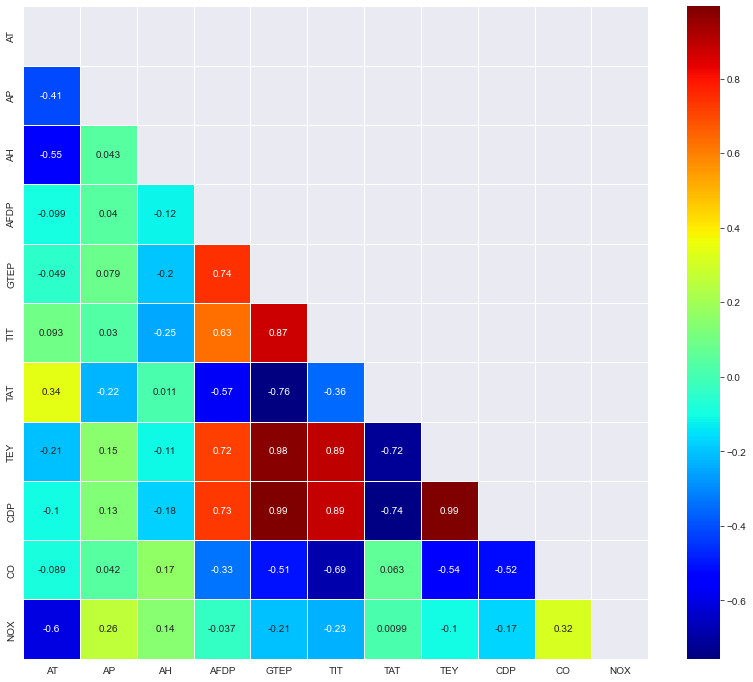

In [19]:
plt.figure(figsize=(14,12))
mask = np.zeros_like(df.corr(), dtype= np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data= df.corr(), cmap= "jet", annot= True, linewidths= 1, linecolor= 'white', mask=mask);

In [20]:
x = df.drop('TEY', axis=1)
y = df[["TEY"]]

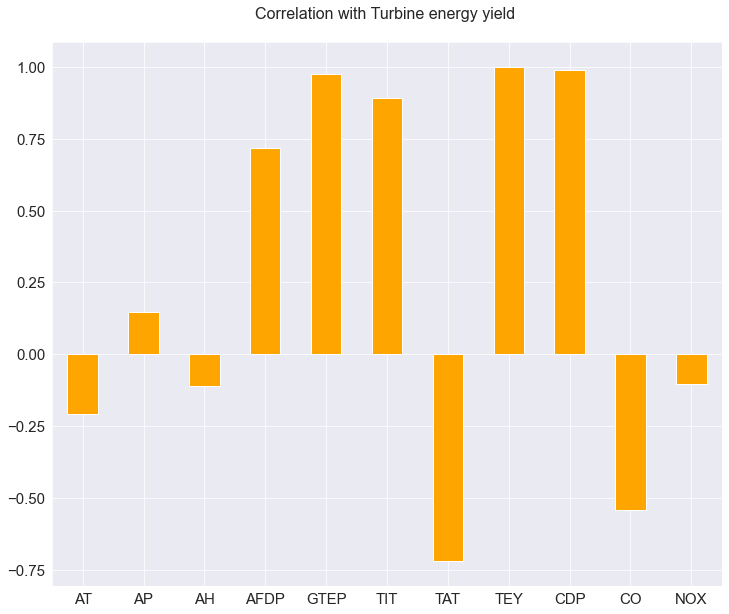

In [21]:
data2 = df.copy()

correlations = data2.corrwith(df.TEY)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations>0].sort_values(ascending = False)
negative_correlations = correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(figsize=(12,10), fontsize = 15, color = 'orange', rot = 0, grid = True)
plt.title('Correlation with Turbine energy yield \n', fontsize = "16", fontfamily = "sans-serif")
plt.show()

## 5. Data Pre-Processing
### 5.1 Feature Selection Technique

In [22]:
from numpy import set_printoptions
from sklearn.feature_selection import mutual_info_regression

### Feature Extraction

In [23]:
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(x, y)

### Summarize Scores

In [24]:
scores = fit.scores_
features = fit.transform(x)

In [25]:
score_df = pd.DataFrame(list(zip(scores, x.columns)), columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
7,1.713055,CDP
4,1.600193,GTEP
5,1.325689,TIT
6,0.894508,TAT
3,0.660762,AFDP
8,0.513069,CO
0,0.412209,AT
9,0.300657,NOX
1,0.135679,AP
2,0.097769,AH


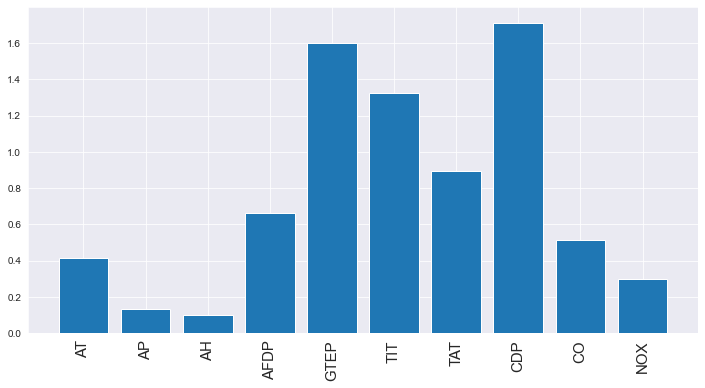

In [26]:
fig, axes = plt.subplots(figsize=(12,6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

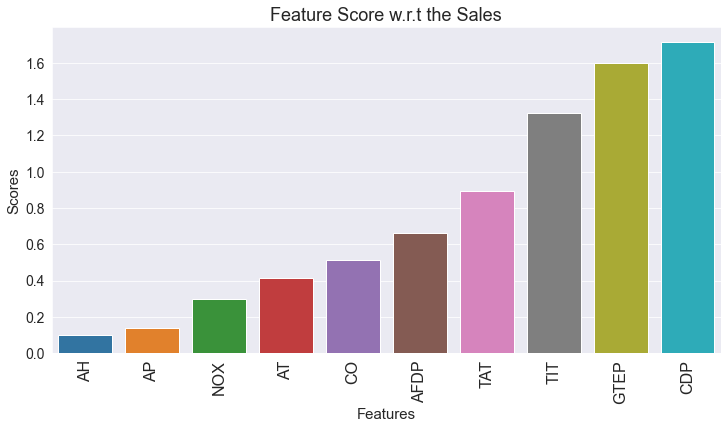

In [27]:
plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y="Score", data=score_df, order=score_df.sort_values('Score').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

In [28]:
score_df.sort_values('Score', ascending=False)

,Score,Feature
7,1.713055,CDP
4,1.600193,GTEP
5,1.325689,TIT
6,0.894508,TAT
3,0.660762,AFDP
8,0.513069,CO
0,0.412209,AT
9,0.300657,NOX
1,0.135679,AP
2,0.097769,AH


In [29]:
model_data = df[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', 'AT',"TEY"]]
model_data.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72


### 5.2 Feature Engineering
#### Applying some Data Transformation to increase the linear realtionship and improve our model prediction as well it scores
### Applying Standard Scaler

In [30]:
continuous_feature=[feature for feature in model_data.columns if model_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 8


In [31]:
df_standard_scaled = model_data.copy()
features = df_standard_scaled[continuous_feature]

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,-1.357331,-1.379101,-1.488376,0.585240,-0.921232,0.532012,-1.439778,-1.231172
1,-1.363676,-1.363528,-1.482325,0.585240,-0.921495,0.568733,-1.449601,-1.229909
2,-1.360957,-1.351309,-1.476275,0.568715,-0.944385,0.552938,-1.434721,-1.230541
3,-1.356424,-1.348194,-1.464173,0.583969,-0.946884,0.548933,-1.413702,-1.229909
4,-1.350985,-1.354663,-1.458123,0.582698,-0.924389,0.574179,-1.368693,-1.229909


In [33]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1))

Mean
 CDP     0.0
GTEP    0.0
TIT    -0.0
TAT     0.0
AFDP    0.0
CO      0.0
AT     -0.0
TEY     0.0
dtype: float64


In [34]:
print('Standard Devaition','\n',np.round(df_standard_scaled.std(),1))

Standard Devaition 
 CDP     1.0
GTEP    1.0
TIT     1.0
TAT     1.0
AFDP    1.0
CO      1.0
AT      1.0
TEY     1.0
dtype: float64


### 5.3 Test Train Split With Imbalanced Dataset

In [35]:
x = df_standard_scaled.drop('TEY',axis=1)
y = df_standard_scaled[['TEY']]

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

## 6. Hyperparameter Tuning

### 6.1 Hyperparameter Tuning: Optimal Learning rate ,Number of Layers and Neurons

In [37]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units = hp.Int('units_' + str(i), min_value=32, max_value=100, step=32), activation='relu'))
    
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error', metrics=['mean_absolute_error'])
    return model

In [38]:
from keras_tuner.tuners import RandomSearch

In [39]:
tuner = RandomSearch(build_model, objective= 'val_mean_absolute_error', max_trials= 5,
                     executions_per_trial= 3, directory= 'project', project_name= 'Gas Turbine')
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project project\Gas Turbine\oracle.json
INFO:tensorflow:Reloading Tuner from project\Gas Turbine\tuner0.json
Search space summary
Default search space size: 13
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 

In [40]:
tuner.search(x_train, y_train,epochs=10,validation_data=(x_test, y_test))

INFO:tensorflow:Oracle triggered exit


In [41]:
tuner.results_summary()

Results summary
Results in project\Gas Turbine
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 11
units_0: 96
units_1: 64
learning_rate: 0.0001
units_2: 64
units_3: 64
units_4: 64
units_5: 96
units_6: 64
units_7: 96
units_8: 64
units_9: 64
units_10: 64
Score: 0.02761391984919707
Trial summary
Hyperparameters:
num_layers: 11
units_0: 96
units_1: 32
learning_rate: 0.001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
Score: 0.028524594381451607
Trial summary
Hyperparameters:
num_layers: 8
units_0: 64
units_1: 64
learning_rate: 0.001
units_2: 64
units_3: 32
units_4: 64
units_5: 64
units_6: 32
units_7: 64
units_8: 96
units_9: 64
units_10: 64
Score: 0.029420504346489906
Trial summary
Hyperparameters:
num_layers: 4
units_0: 64
units_1: 64
learning_rate: 0.01
units_2: 32
units_3: 96
units_4: 64
units_5: 64
units_6: 96
units_7: 96
units_8: 96
units_9: 64
units_10: 96
Score: 0.03023434119919936
Trial summary
Hyperpar

### 6.2 Hyperparameter Tuning: Optimal Batch_size, Number of Epochs

In [42]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim=7,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))
    
    adam=Adam(learning_rate=0.001)
    model1.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model1

In [43]:
model1     = KerasRegressor(build_fn=create_model,verbose=0)
batch_size = [10,20,40,50]
epochs     = [10,50,100,200]
param_grid = dict(batch_size= batch_size, epochs= epochs)
grid = GridSearchCV(estimator= model1, param_grid= param_grid, cv= KFold(), verbose= 10)

In [44]:
grid_result = grid.fit(x_test,y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=10, epochs=10...................................
[CV 1/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.060 total time=   8.9s
[CV 2/5; 1/16] START batch_size=10, epochs=10...................................
[CV 2/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.051 total time=  11.9s
[CV 3/5; 1/16] START batch_size=10, epochs=10...................................
[CV 3/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.031 total time=   7.1s
[CV 4/5; 1/16] START batch_size=10, epochs=10...................................
[CV 4/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.037 total time=   7.5s
[CV 5/5; 1/16] START batch_size=10, epochs=10...................................
[CV 5/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.048 total time=  12.1s
[CV 1/5; 2/16] START batch_size=10, epochs=50...................................
[CV 1/5; 2/16] END ...batch_size=10, epochs=50;,

[CV 1/5; 11/16] END .batch_size=40, epochs=100;, score=-0.029 total time=  19.3s
[CV 2/5; 11/16] START batch_size=40, epochs=100.................................
[CV 2/5; 11/16] END .batch_size=40, epochs=100;, score=-0.032 total time=  17.9s
[CV 3/5; 11/16] START batch_size=40, epochs=100.................................
[CV 3/5; 11/16] END .batch_size=40, epochs=100;, score=-0.033 total time=  19.1s
[CV 4/5; 11/16] START batch_size=40, epochs=100.................................
[CV 4/5; 11/16] END .batch_size=40, epochs=100;, score=-0.032 total time=  18.2s
[CV 5/5; 11/16] START batch_size=40, epochs=100.................................
[CV 5/5; 11/16] END .batch_size=40, epochs=100;, score=-0.026 total time=  17.7s
[CV 1/5; 12/16] START batch_size=40, epochs=200.................................
[CV 1/5; 12/16] END .batch_size=40, epochs=200;, score=-0.030 total time=  37.6s
[CV 2/5; 12/16] START batch_size=40, epochs=200.................................
[CV 2/5; 12/16] END .batch_s

In [45]:
print('Best {}, using {}'.format(grid_result.best_score_, grid_result.best_params_))
means  = grid_result.cv_results_["mean_test_score"]
stds   = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means, stds,params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.03010711632668972, using {'batch_size': 40, 'epochs': 200}
-0.04541852250695229, 0.010160187533181826 with {'batch_size': 10, 'epochs': 10}
-0.03697356656193733, 0.005233119048711083 with {'batch_size': 10, 'epochs': 50}
-0.03231152892112732, 0.0024109754587596515 with {'batch_size': 10, 'epochs': 100}
-0.031559351831674576, 0.0018844355021909477 with {'batch_size': 10, 'epochs': 200}
-0.044509153068065646, 0.005313963186506471 with {'batch_size': 20, 'epochs': 10}
-0.033160609379410746, 0.0036745168234104284 with {'batch_size': 20, 'epochs': 50}
-0.03140661455690861, 0.003007952871872297 with {'batch_size': 20, 'epochs': 100}
-0.032513809576630595, 0.007064991345632939 with {'batch_size': 20, 'epochs': 200}
-0.04286637380719185, 0.00872672726968649 with {'batch_size': 40, 'epochs': 10}
-0.03748258426785469, 0.00932771533696016 with {'batch_size': 40, 'epochs': 50}
-0.030477942898869514, 0.0026375146314723615 with {'batch_size': 40, 'epochs': 100}
-0.03010711632668972, 0.001959

### 6.3 Hyperparameter Tuning: Optimal Droupout rate

In [46]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(32,input_dim=7,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(units=1,activation="linear"))
    
    adam = Adam(lr=0.001)
    model2.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model2

In [47]:
model2       = KerasRegressor(build_fn= create_model, batch_size= 40, epochs= 200, verbose= 0)
dropout_rate = [0.0,0.1,0.2,0.3,0.4,0.5]
param_grid   = dict(dropout_rate= dropout_rate)
grid2        = GridSearchCV(estimator= model2, param_grid= param_grid, cv= KFold(), verbose= 10)

In [48]:
grid_result2 = grid2.fit(x_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
[CV 1/5; 1/6] END ............dropout_rate=0.0;, score=-0.032 total time=  28.7s
[CV 2/5; 1/6] START dropout_rate=0.0............................................
[CV 2/5; 1/6] END ............dropout_rate=0.0;, score=-0.034 total time=  25.8s
[CV 3/5; 1/6] START dropout_rate=0.0............................................
[CV 3/5; 1/6] END ............dropout_rate=0.0;, score=-0.032 total time=  29.1s
[CV 4/5; 1/6] START dropout_rate=0.0............................................
[CV 4/5; 1/6] END ............dropout_rate=0.0;, score=-0.026 total time=  35.4s
[CV 5/5; 1/6] START dropout_rate=0.0............................................
[CV 5/5; 1/6] END ............dropout_rate=0.0;, score=-0.026 total time=  36.9s
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END ............dropout_rate=0.1;, 

In [49]:
print('Best {}, using {}'.format(grid_result2.best_score_, grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds  = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means, stds, params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.02847818545997143, using {'dropout_rate': 0.2}
-0.029861985146999358, 0.003220468050446664 with {'dropout_rate': 0.0}
-0.033183705434203147, 0.00532062770038219 with {'dropout_rate': 0.1}
-0.02847818545997143, 0.0017855292768304382 with {'dropout_rate': 0.2}
-0.03269175477325916, 0.004902988211977932 with {'dropout_rate': 0.3}
-0.03156960271298885, 0.0016918504586346348 with {'dropout_rate': 0.4}
-0.035478489473462105, 0.006231287434233802 with {'dropout_rate': 0.5}


### 6.4 Hyperparameter Tuning: Optimal Activation Function and Kernel Initializer

In [50]:
def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(32,input_dim=7,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(units=1,activation="linear"))
    
    adam = Adam(lr=0.001)
    model3.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model3

In [51]:
model3 = KerasRegressor(build_fn=create_model, batch_size=40,epochs=200,verbose=0)
activation_function = ['softmax','tanh','relu']
init = ['normal','uniform','zero']
param_grid = dict(activation_function= activation_function, init= init)
grid3 = GridSearchCV(estimator= model3, param_grid= param_grid, cv= KFold(), verbose=10)

In [52]:
grid_result3 = grid3.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START activation_function=softmax, init=normal....................
[CV 1/5; 1/9] END activation_function=softmax, init=normal;, score=-0.273 total time= 1.1min
[CV 2/5; 1/9] START activation_function=softmax, init=normal....................
[CV 2/5; 1/9] END activation_function=softmax, init=normal;, score=-0.744 total time= 1.0min
[CV 3/5; 1/9] START activation_function=softmax, init=normal....................
[CV 3/5; 1/9] END activation_function=softmax, init=normal;, score=-0.216 total time= 1.0min
[CV 4/5; 1/9] START activation_function=softmax, init=normal....................
[CV 4/5; 1/9] END activation_function=softmax, init=normal;, score=-0.663 total time= 1.0min
[CV 5/5; 1/9] START activation_function=softmax, init=normal....................
[CV 5/5; 1/9] END activation_function=softmax, init=normal;, score=-0.674 total time= 1.0min
[CV 1/5; 2/9] START activation_function=softmax, init=uniform.........

In [53]:
print('Best {}, using {}'.format(grid_result3.best_score_, grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds  = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means, stds, params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.513939693570137, using {'activation_function': 'softmax', 'init': 'normal'}
-0.513939693570137, 0.22249035390743335 with {'activation_function': 'softmax', 'init': 'normal'}
-0.6251876771450042, 0.23549977395440902 with {'activation_function': 'softmax', 'init': 'uniform'}
-0.7084927558898926, 0.05265822613972887 with {'activation_function': 'softmax', 'init': 'zero'}
-0.7946629405021668, 0.09639018828582546 with {'activation_function': 'tanh', 'init': 'normal'}
-0.7443243026733398, 0.061163348646455465 with {'activation_function': 'tanh', 'init': 'uniform'}
-0.628781521320343, 0.22623103495038113 with {'activation_function': 'tanh', 'init': 'zero'}
-0.8250841617584228, 0.08872893891260816 with {'activation_function': 'relu', 'init': 'normal'}
-0.7635827422142029, 0.08829327248908983 with {'activation_function': 'relu', 'init': 'uniform'}
-0.8415626764297486, 0.07237225130822898 with {'activation_function': 'relu', 'init': 'zero'}


## 7. Model Building Neural Networks
### Standardizing only predictor variable - after train test split

In [54]:
model_data

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72
...,...,...,...,...,...,...,...,...
15034,10.400,19.164,1049.7,546.21,3.5421,4.5186,9.0301,111.61
15035,10.433,19.414,1046.3,543.22,3.5059,4.8470,7.8879,111.78
15036,10.483,19.530,1037.7,537.32,3.4770,7.9632,7.2647,110.19
15037,10.533,19.377,1043.2,541.24,3.4486,6.2494,7.0060,110.74


### Assigning predictor variables to x and response variable to y

In [55]:
x = model_data.drop('TEY', axis=1)
y = model_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data -- predictor
x_test_scaled  = scaler_test.fit_transform(x_test)   # scaling test data -- predictor

print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(12031, 7)
(3008, 7)
(12031, 1)
(3008, 1)


### Since we have continuous ouput, AF is not required in the o/p layer

In [ ]:
model = Sequential()
model.add( Dense(units= 50, activation= 'relu', kernel_initializer= 'normal', input_dim= 7)) # input layer
model.add( Dense(units= 20, activation= 'tanh', kernel_initializer= 'normal')) # hidden layer
model.add( Dense(units= 1, kernel_initializer= 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss= "mse", metrics= ["mae", "mse"])
history = model.fit(x_train_scaled, y_train, batch_size= 50, validation_split= 0.3, epochs=10,  verbose=1)

In [56]:
def toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test):
        
    # Defining list of hyperparameters
    batch_size_list = [10 , 15 , 20 ]
    epoch_list      = [10 , 50 , 100]
     
    bestParamTable = pd.DataFrame()
    
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:
            
            # Create ANN model
            model = Sequential()
            
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train_scaled.shape[1], kernel_initializer='normal', activation='relu'))
            
            # Defining the Second layer of the model
            model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))
 
            # The output neuron is a single fully connected node Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')
            
            # Fitting the ANN to the Training set
            model.fit(x_train_scaled, y_train , batch_size=batch_trial, epochs=epochs_trial,  verbose=0)
                        
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(x_test_scaled))/y_test))  
                        
            bestParamTable=bestParamTable.append(pd.DataFrame(data=[[batch_trial, epochs_trial, 100-MAPE]], columns=['batchsize','epochs','Accuracy'] ))
            
            # Printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:', epochs_trial, 'Accuracy:', 100-MAPE)

    return bestParamTable

# Calling the function
finalParamTable = toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test)

94/94 [==============================] - 0s 2ms/step
batch_size: 10 - epochs: 10 Accuracy: TEY    98.536054
dtype: float64
94/94 [==============================] - 0s 958us/step
batch_size: 10 - epochs: 50 Accuracy: TEY    99.568202
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 100 Accuracy: TEY    99.577327
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 15 - epochs: 10 Accuracy: TEY    89.836666
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 15 - epochs: 50 Accuracy: TEY    99.624703
dtype: float64
94/94 [==============================] - 0s 3ms/step
batch_size: 15 - epochs: 100 Accuracy: TEY    99.653789
dtype: float64
94/94 [==============================] - 0s 2ms/step
batch_size: 20 - epochs: 10 Accuracy: TEY    81.096263
dtype: float64
94/94 [==============================] - 0s 3ms/step
batch_size: 20 - epochs: 50 Accuracy: TEY    99.619879
dtype: float64
94/94 [=====

### Getting corresponding row values of the maximum value of 'Accuracy' column

### Training Model - using best params

In [57]:
model.compile(optimizer ='adam', loss = 'mean_squared_error')

model.fit(x_train_scaled,y_train, batch_size= 20, epochs= 10, verbose= 0)

NameError: name 'model' is not defined

### 7.1 Model Evaluation Train and Test Error

### 7.2 Predicting values from Model using same dataset

In [ ]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

In [ ]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO','AT'], axis= 1 , inplace= True)

### 7.3 Calculating Absolute Percent Error and Error

In [ ]:
# Computing the absolute percent error
APE = 100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %'] = APE
predictions_df.head()

In [ ]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

### 7.4 Visualizing the Relationship between the Actual and Predicted ValuesModel Validation

In [ ]:
plt.figure(figsize=(9,6))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])

#### We will evaluate our model performance by calculating the residual sum of squares and the explained variance score

In [ ]:
from sklearn import metrics
print("MAE  :",metrics.mean_absolute_error(y_test,y_predict_test))
print("MSE  :",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE :",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled) 
print('R2_score (train) : ',r2_score(y_train, y_predict_train))
print('R2_score (test)  : ',r2_score(y_test, y_predict_test))

### Evaluation of  the explained variance score (R^2)

In [ ]:
print('This shows our model predict % {} of the target correctly'.format(np.round(metrics.explained_variance_score(y_test,y_predict_test)*100,2))) 

### 7.5 Residual Analysis

### Test for Normality of Residuals (Q-Q Plot)

In [ ]:
# Now we will visualize the differences between our predictions and actual y test data
plt.figure(figsize=(9,6))
sns.distplot(y_test-y_predict_test,bins=50) # this figure also proves that our model fits very good

#### There is no huge differences between our predictions and actual y data

In [ ]:
import statsmodels.api as smf
plt.rcParams["figure.figsize"] = (9,6)
smf.qqplot(predictions_df['Error'], line= 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()

### Observation: Error should have Normal / Gaussian distribution~N(0,1) and independently and identically distributed.

# The End !!